### Description
Recommodation system is use to predict or recommend value or products to customers. In our case we will be recommending academic carrer scores to Thanos so he can decide on the people to reduce to dust. A recommendation system tries to understand the relationship between a dataset and predict missing values or recommend products to users.

#### Algorithms recommendation systems 
1. Content based filtering 
2. Collaborative filtering
    - planet planet collaborative filtering
    - person person collaborative filtering 
3. Knowledge based filtering 
4. Matrix factorization



In [71]:
### Exploratory data analysis(EDA)

In [72]:
import pandas as pd 
import numpy as np
#import training data
train_data = pd.read_csv("dataset/train.data")
#train_data
test_data = pd.read_csv("dataset/test.data")
#test_data

In [73]:
train_data.shape

(704107, 3)

In [74]:
test_data.shape

(78235, 2)

In [75]:
#Check if there are some persons in the test set that are not in the training set 
planet_train =  train_data.planet.unique()
planet_test =  test_data.planet.unique()
set(planet_test).difference(planet_train)


set()

In [76]:
n_planet = train_data.planet.unique().shape[0] 
print(n_planet)

5000


In [77]:
highest_planet_id = train_data['planet'].max()
print(highest_planet_id)

4999


In [78]:
#Note the number of unique person is not equal to the person with the highest value
n_person = train_data.person.unique().shape[0] 
print(n_person)

3598


In [79]:
highest_person_id = train_data['person'].max()
print(highest_person_id)

3899


In [80]:
n_score = train_data.score.unique().shape[0] 
print(n_score)

5


In [81]:
#train_data.sort_values(by=['planet'], ascending = False)

## Collaborative filtering 
For planet-planet collaborative filtering, we find similarities between planets, based on this similarities we recommend scores for people in those planets. 

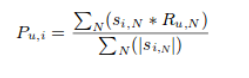

For person-person collaborative filtering, we find the similarities between persons, based on that we recommend scores

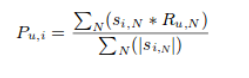

In [82]:
# Creating planet - person matrix to find the similarities between them 
planet_person_matrix = np.zeros((highest_planet_id, highest_person_id))
for line in train_data.itertuples():
    planet_person_matrix[line[1]-1, line[2]-1] = line[3]

In [83]:
# We use sklearn library to calculate similarities
from sklearn.metrics.pairwise import pairwise_distances 
planet_similarity = pairwise_distances(planet_person_matrix, metric='cosine')
person_similarity = pairwise_distances(planet_person_matrix.T, metric='cosine')

In [84]:
def predict(matrix, similarity, type='planet'):
    if type == 'planet':
        mean_planet_score = matrix.mean(axis=1)
        score_diff = (matrix - mean_planet_score[:, np.newaxis])
        pred = mean_planet_score[:, np.newaxis] + similarity.dot(score_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
        print("Planet - planet collaborative filtering")
        print(pred)
    elif type == 'person':
        pred = matrix.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
        print("Person - person collaborative filtering")
        print(pred)
    return pred

In [85]:
planet_prediction = predict(planet_person_matrix, planet_similarity, type='planet')


Planet - planet collaborative filtering
[[-0.01942323  0.02107529  0.3648367  ... -0.03466033 -0.03387325
   0.08480908]
 [-0.06684876 -0.02595905  0.33028002 ... -0.08114582 -0.0815607
   0.04222054]
 [-0.03522653  0.01034071  0.36013823 ... -0.04952257 -0.04963236
   0.06957824]
 ...
 [-0.07246612 -0.02816645  0.31258735 ... -0.08719984 -0.08731273
   0.03212811]
 [ 0.13061695  0.1732889   0.51029878 ...  0.11663003  0.1156225
   0.23383446]
 [ 0.02130384  0.06155214  0.39064321 ...  0.00672171  0.00656905
   0.12370521]]


In [86]:
person_prediction = predict(planet_person_matrix, person_similarity, type='person')

Person - person collaborative filtering
[[0.0766071  0.07313709 0.0684293  ... 0.07515959 0.07791281 0.07367897]
 [0.03342887 0.03081504 0.03030653 ... 0.03361054 0.03359386 0.03270824]
 [0.0630078  0.06308569 0.05875232 ... 0.06354606 0.0643545  0.06055578]
 ...
 [0.02800294 0.02721143 0.02362549 ... 0.02801665 0.02833357 0.02623697]
 [0.21985941 0.21666893 0.20329238 ... 0.22222736 0.21895846 0.2153902 ]
 [0.11466983 0.10924265 0.09735815 ... 0.11521554 0.11582949 0.10915748]]


In [87]:

from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [88]:

#print ('User-based bias-adjusted CF RMSE: %.2f' %rmse(planet_prediction, train_data['planet']))
#print ('Item-based bias-adjusted CF RMSE: %.2f' %rmse(person_prediction, train_data['person']))

## Matrix factorization

This require latent features that helps to remove noise from data by removing the features which does not determine a person in a planet get a score5

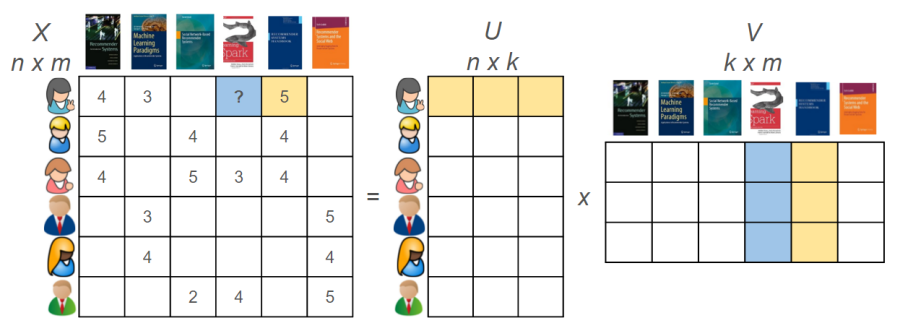

### matrix factorization

+ create the __init__ method to initialize important variables 

+ create create_features method 
    It create P which is the planet feature affinity matrix, it represents the association between planets and freatures 
    It create Q which is the person features affinity matrix, it represents the association between person and features

In [89]:
class matrix_factorization():
    
    #initialling the important variables in the contructor method 
    
    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, planet_person, latent_feature, alpha, beta, iterations):
        
        #initizating variables gotten from the data
        self.planet_person = planet_person
        self.n_planets, self.n_persons = planet_person.shape
        self.latent_feature = latent_feature
        
        #initialize hypermeters
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing planet-feature and person-feature matrix 
    def model(self):
        self.P = np.random.normal(scale=1./self.latent_feature, size=(self.n_planets, self.latent_feature))
        self.Q = np.random.normal(scale=1./self.latent_feature, size=(self.n_persons, self.latent_feature))

        # Initializing the bias
        self.b_pl = np.zeros(self.n_planets)
        self.b_pe = np.zeros(self.n_persons)
        self.b = np.mean(self.planet_person[np.where(self.planet_person != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.planet_person[i, j])
        for i in range(self.n_planets)
        for j in range(self.n_persons)
        if self.planet_person[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 1 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.planet_person.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.planet_person[x, y] - predicted[x, y], 2)
        print(predicted.shape[0])
        mse = error / predicted.shape[0]
        return np.sqrt(mse)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_pl[i] += self.alpha * (e - self.beta * self.b_pl[i])
            self.b_pe[j] += self.alpha * (e - self.beta * self.b_pe[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_pl[i] + self.b_pe[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_pl[:,np.newaxis] + mf.b_pe[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [90]:
# create planet-person matrix and fill the empty cell with 0
planet_person = np.array(train_data.pivot(index = 'planet', columns ='person', values = 'score').fillna(0))


In [91]:

sparsity = float(len(planet_person_matrix.nonzero()[0]))
sparsity /= (planet_person_matrix.shape[0] * planet_person_matrix.shape[1])
sparsity *= 100
print ('percentage of user-items that have a rating: {:.2f}%'.format(sparsity))

percentage of user-items that have a rating: 3.61%


In [92]:
mf = matrix_factorization(planet_person, latent_feature=20, alpha=0.001, beta=0.01, iterations=2)
training_process = mf.model()
print()
print("P x Q:")
print(mf.full_matrix())
print()

5000
Iteration: 1 ; error = 11.9830
5000
Iteration: 2 ; error = 11.5288

P x Q:
[[3.57030806 3.4611816  3.87091448 ... 3.56850429 3.54701953 3.77288331]
 [3.52009379 3.41521231 3.81879207 ... 3.53046353 3.52580526 3.70566691]
 [3.55901913 3.42974408 3.8606878  ... 3.57328448 3.56075643 3.76654531]
 ...
 [3.5729296  3.45155625 3.85519483 ... 3.57224092 3.55257275 3.76701693]
 [3.51926081 3.41738377 3.82396885 ... 3.55895411 3.54910629 3.73712327]
 [3.55462705 3.45084347 3.86008493 ... 3.5648307  3.57204293 3.77590546]]



In [93]:
print(mf.mse())

5000
11.528764344111124


In [94]:
Evaluation metrics 

SyntaxError: invalid syntax (<ipython-input-94-d6bf714f072f>, line 1)

https://github.com/yinniyu/Collaborative_filtering/blob/master/music_recommender.ipynb

https://github.com/apple/turicreate/issues/506